In [1]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pylab import subplots_adjust
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils.metric import *

In [2]:
# Configuration
DATASET_PATH = './dataset/SWINySEG'
DATASET_SPLIT = 'all'


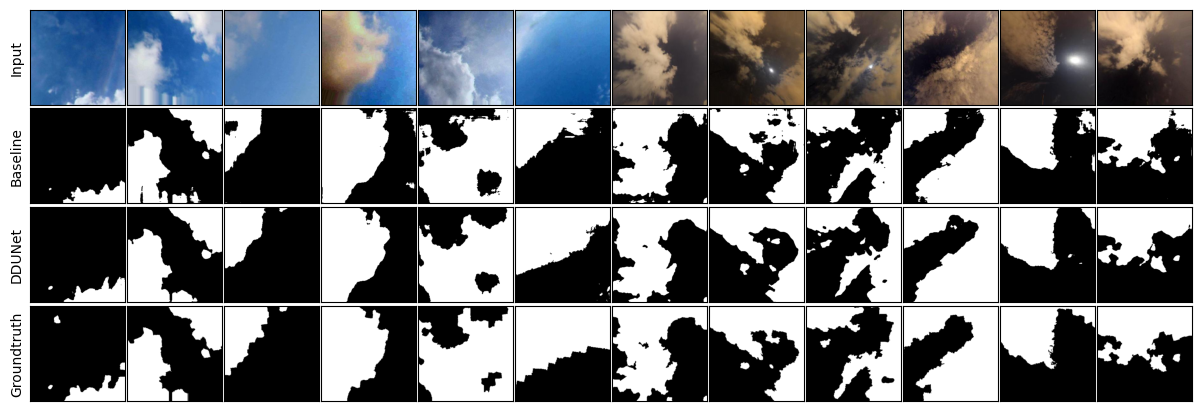

In [35]:
# test on UCloudNet (k=4, aux, lr decay)
img_path = './dataset/SWINySEG/images'
gt_path = './dataset/SWINySEG/GTmaps'

n_images = 12
images_names = [
    'd0107_5.jpg', 'd0310_2.jpg', 'd0914.jpg', 'd0926_3.jpg', 'd0004_4.jpg', 'd0782_1.jpg',
    'n0084.jpg', 'n0105_1.jpg', 'n0104_2.jpg', 'n0039_2.jpg', 'n0028_3.jpg', 'n0093_1.jpg']

plt.figure(figsize=(15, 15))
i = 1
for item in images_names:
    ax = plt.subplot(5, n_images, i)
    if (i-1) % n_images == 0:
        ax.set_ylabel('Input')
    img = Image.open(
        os.path.join(img_path, images_names[(i-1) % n_images])).resize((304, 304))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1

from models.ddunet_baseline import DDUNet
model = DDUNet(3, 8)
model.set_state_dict(paddle.load("./weights/ddunet_c8_baseline_e100.pdparam"))
model.eval()
for item in images_names:
    ax = plt.subplot(5, n_images, i)
    if (i-1) % n_images == 0:
        ax.set_ylabel("Baseline")
    img = Image.open(
        os.path.join(img_path, images_names[(i-1) % n_images])).resize((304, 304))
    img_tensor = paddle.to_tensor(
        np.array(img).transpose(2, 0, 1).reshape((1, 3, 304, 304))).astype('float32') / 255
    img_tensor = (img_tensor-0.5)/0.5
    pred = model(img_tensor)
    pred = (F.sigmoid(pred)>0.5).astype('int64')
    pred = Image.fromarray(np.uint8(pred.numpy().reshape((304, 304))) * 255)
    plt.imshow(pred, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    i += 1

from models.ddunet import DDUNet
model = DDUNet(3, 8)
model.set_state_dict(paddle.load("./weights/ddunet_c8_full_e100.pdparam"))
model.eval()
for item in images_names:
    ax = plt.subplot(5, n_images, i)
    if (i-1) % n_images == 0:
        ax.set_ylabel("DDUNet")
    img = Image.open(
        os.path.join(img_path, images_names[(i-1) % n_images])).resize((304, 304))
    img_tensor = paddle.to_tensor(
        np.array(img).transpose(2, 0, 1).reshape((1, 3, 304, 304))).astype('float32') / 255
    img_tensor = (img_tensor-0.5)/0.5
    pred = model(img_tensor)
    pred = (F.sigmoid(pred)>0.5).astype('int64')
    pred = Image.fromarray(np.uint8(pred.numpy().reshape((304, 304))) * 255)
    plt.imshow(pred, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    i += 1

for item in images_names:
    ax = plt.subplot(5, n_images, i)
    if (i-1) % n_images == 0:
        ax.set_ylabel('Groundtruth')
    gt = Image.open(
        os.path.join(
            gt_path, 
            images_names[(i-1) % n_images].split(".")[0]+".png")).resize((304, 304))
    plt.imshow(gt, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    i += 1



plt.subplots_adjust(wspace=0.02, hspace=-0.87)
plt.savefig('./results/test_pred.svg', format='svg', bbox_inches='tight')
plt.show()
# left=0.6, top=0.6, right=1.7, bottom=0.1, 

In [7]:
from paddle.io import DataLoader
from utils.dataset import SWINySEG
from utils.progressbar import ProgressBar

os.makedirs("./results/predictions")

from models.ddunet_baseline import DDUNet
model = DDUNet(3, 8)
model.set_state_dict(paddle.load("./weights/ddunet_c8_baseline_e100.pdparam"))
model.eval()

testset = SWINySEG("./dataset/SWINySEG", 'n', 'val')
loader = DataLoader(testset, batch_size=1, shuffle=False)

bar = ProgressBar(maxStep=len(loader()))
for i, (image, label) in enumerate(loader()):
    pred = model(image)
    pred = (F.sigmoid(pred)>0.5).astype('int64')
    pred = Image.fromarray(np.uint8(pred.numpy().reshape((304, 304))) * 255)
    bar.updateBar(i, {}, {})
    pred.save("./results/predictions/{}.png".format(i))

[100.0%]: [##################  ] 